# Hyperparameter tune VIT model on All Hurricanes

In [13]:
import os
import math
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from shapely.geometry import MultiPolygon, Polygon
import shapely
from shapely import wkt

import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch import tensor

import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms, utils
import torch.utils.data
from torcheval.metrics.functional import multiclass_precision, multiclass_f1_score, multiclass_recall, multiclass_accuracy
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import WeightedRandomSampler
from torchsummary import summary

import cv2
from PIL import Image

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from numpy import where

import optuna


# from skorch import NeuralNetClassifier
# from skorch.helper import predefined_split
# from skorch.callbacks import LRScheduler, Checkpoint, Freezer, EarlyStopping
# from sklearn.model_selection import GridSearchCV






torch.manual_seed(360);

### Setup Current Directory

In [14]:
print("Current Path : ", os.getcwd())
os.chdir('../..')
print("Current Path : ", os.getcwd())

Current Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/cleaned_repo/alivio/src/04_models
Current Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/cleaned_repo/alivio


In [15]:
ROOT_DIR = os.getcwd()
print("Root Project Path : ", ROOT_DIR)
ROOT_DATA_DIR = os.path.join(ROOT_DIR, 'data', 'xview_building_damage')
CSV_DIR = os.path.join(ROOT_DATA_DIR, 'csv')
print("Data CSV Path : ", CSV_DIR)
TRAIN_DIR=os.path.join(ROOT_DATA_DIR, 'train')
print("Train Data Path : ", TRAIN_DIR)
HOLD_DIR=os.path.join(ROOT_DATA_DIR, 'hold')
print("Validation Data Path : ", HOLD_DIR)
TEST_DIR=os.path.join(ROOT_DATA_DIR, 'test')
print("Test Data Path : ", TEST_DIR)

Root Project Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/cleaned_repo/alivio
Data CSV Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/cleaned_repo/alivio/data/xview_building_damage/csv
Train Data Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/cleaned_repo/alivio/data/xview_building_damage/train
Validation Data Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/cleaned_repo/alivio/data/xview_building_damage/hold
Test Data Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/cleaned_repo/alivio/data/xview_building_damage/test


### Load the data

In [16]:
def get_label_stats(data_loader):
    labels = [labels for i, (images, labels) in enumerate(data_loader)]
    labels = torch.cat((labels), 0)
    labels_count = labels.unique(return_counts=True)
    
    print('The number of samples per classes in training dataset:\n')
    for label, count in zip(labels_count[0], labels_count[1]):
        print('\t {}: {}'.format(label, count))
    return labels, labels_count

In [17]:
train_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2,p=0.5),
    transforms.RandomAutocontrast(p=0.5),
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

valid_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),    
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), 
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

test_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),    
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), 
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [18]:
train_all_dataset = datasets.ImageFolder(os.path.join(TRAIN_DIR, 'img_mask_ov_crop_class'), transform=train_transform)
valid_all_dataset = datasets.ImageFolder(os.path.join( HOLD_DIR, 'img_mask_ov_crop_class'), transform=valid_transform)
test_all_dataset = datasets.ImageFolder(os.path.join( TEST_DIR, 'img_mask_ov_crop_class'), transform=test_transform)
print("Train set records : ", len(train_all_dataset))
print("Validation set records : ", len(valid_all_dataset))
print("Test set records : ", len(test_all_dataset))

trainset_all = torch.utils.data.Subset(train_all_dataset, list(range(len(train_all_dataset))))
testset_all = torch.utils.data.Subset(test_all_dataset, list(range(len(test_all_dataset))))
validset_all = torch.utils.data.Subset(valid_all_dataset, list(range(len(valid_all_dataset))))

#sampler = torch.utils.data.sampler.WeightedRandomSampler(element_weights, num_epoch_elements, replacement=False)

batch_size = 128

# prepare data loaders
train_loader_all = DataLoader(trainset_all, batch_size=batch_size, num_workers=2)
valid_loader_all = DataLoader(validset_all, batch_size=batch_size, num_workers=2)
test_loader_all = DataLoader(testset_all, batch_size=batch_size, num_workers= 2)

Train set records :  64454
Validation set records :  22107
Test set records :  19299


In [19]:
class_names = train_all_dataset.classes
print("class_names ",class_names)

class_dict = train_all_dataset.class_to_idx
print("class_dict ",class_dict)

class_names  ['destroyed', 'major-damage', 'minor-damage', 'no-damage']
class_dict  {'destroyed': 0, 'major-damage': 1, 'minor-damage': 2, 'no-damage': 3}


In [20]:
print("================================================")
print(f"Train data:\n{train_all_dataset}")
print(f"Validation data:\n{valid_all_dataset}")
print(f"Test data:\n{test_all_dataset}")

Train data:
Dataset ImageFolder
    Number of datapoints: 64454
    Root location: /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/cleaned_repo/alivio/data/xview_building_damage/train/img_mask_ov_crop_class
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomAdjustSharpness(sharpness_factor=2,p=0.5)
               RandomAutocontrast(p=0.5)
               ToTensor()
           )
Validation data:
Dataset ImageFolder
    Number of datapoints: 22107
    Root location: /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/cleaned_repo/alivio/data/xview_building_damage/hold/img_mask_ov_crop_class
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
    

In [21]:
train_all_labels, train_all_labels_count = get_label_stats(train_loader_all)

The number of samples per classes in training dataset:

	 0: 3359
	 1: 13330
	 2: 14550
	 3: 33215


In [22]:
valid_all_labels, valid_all_labels_count = get_label_stats(valid_loader_all)

The number of samples per classes in training dataset:

	 0: 1251
	 1: 4133
	 2: 6192
	 3: 10531


In [23]:
test_labels, test_labels_count = get_label_stats(test_loader_all)

The number of samples per classes in training dataset:

	 0: 1068
	 1: 3500
	 2: 4623
	 3: 10108


In [24]:
def get_class_weights(labels):
    class_counts = np.bincount(labels)
    num_classes = len(class_counts)
    total_samples = len(labels)
    
    class_weights = []
    for count in class_counts:
        weight = 1 / (count / total_samples)
        class_weights.append(weight)
    
    return class_weights

In [25]:
class_weights_all=get_class_weights(train_all_labels)
print("Class weights", class_weights_all)

class_weights_all = torch.tensor(class_weights_all, dtype=torch.float32).to('cpu')
# balanced sampler
weights_all = class_weights_all[train_all_labels]
ws_all = WeightedRandomSampler(weights_all, len(weights_all), replacement=True)

Class weights [19.18844894313784, 4.835258814703676, 4.429828178694158, 1.9405088062622307]


In [26]:
train_loader_ws_all = DataLoader(trainset_all, batch_size=batch_size, sampler=ws_all , num_workers=2)

In [27]:
train_labels_ws_all, train_labels_count_ws_all = get_label_stats(train_loader_ws_all)

#train_labels_ws, train_labels_count_ws = get_label_stats(train_loader_ws)

The number of samples per classes in training dataset:

	 0: 16109
	 1: 16129
	 2: 16060
	 3: 16156


In [42]:
len(valid_loader_all)

173

### Model Training

In [19]:
def get_metrics(preds_list, target_list, num_classes = 4 ):
    pred_ts=tensor(preds_list)
    target_ts = tensor(target_list)
    
    accuracy = multiclass_accuracy(pred_ts, target_ts, num_classes=4)
    
    f1_score = multiclass_f1_score(pred_ts, target_ts, num_classes=4, average="weighted")
    
    precision = multiclass_precision(pred_ts, target_ts, num_classes=4, average="weighted")
    recall = multiclass_recall(pred_ts, target_ts, num_classes=4, average="weighted")
    
    print("Accuracy :", accuracy)
    print("F1-score : ", f1_score)
    print("Precision : ", precision)
    print("Recall : ", recall)

In [29]:
model_name = "vit_base_patch16_224"
def setup_device():
    device = 'cpu' 
    if torch.cuda.is_available(): 
     device='cuda'
    elif torch.backends.mps.is_available():
     device = 'mps' 
    
    print("device = ", device)
    return device

In [30]:
def get_vit_model():
    vision_transformer = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
    print("=============================== Model heads ==========================")
    print(vision_transformer.heads)
    # fine-tune with dataset

    # change the number of output classes
    vision_transformer.heads = nn.Linear(in_features=768, out_features=len(class_names), bias=True)
    
    # freeze the parameters except the last linear layer
    #
    # freeze weights
    for p in vision_transformer.parameters():
        p.requires_grad = False
    
    # unfreeze weights of classification head to train
    for p in vision_transformer.heads.parameters():
        p.requires_grad = True

    print("=============================== Model Layers ==========================")
    for layer_name, p in vision_transformer.named_parameters():
        print('Layer Name: {}, Frozen: {}'.format(layer_name, not p.requires_grad))
        print()

    return vision_transformer

In [22]:
def get_vit_model_with_classes(number_of_classes=4):
    vision_transformer = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
    # fine-tune with dataset
    # change the number of output classes
    vision_transformer.heads = nn.Linear(in_features=768, out_features=number_of_classes, bias=True)
    
    # freeze the parameters except the last linear layer
    #
    # freeze weights
    for p in vision_transformer.parameters():
        p.requires_grad = False
    
    # unfreeze weights of classification head to train
    for p in vision_transformer.heads.parameters():
        p.requires_grad = True

    return vision_transformer

In [31]:
def calculate_weight_decay(batch, train_data_len, nepoches, lambda_norm):
    return lambda_norm * math.sqrt((batch/(train_data_len * nepoches)))

In [24]:
def get_focal_loss(ce_loss, alpha =0.3 ,gamma =2):
    pt = torch.exp(-ce_loss)
    focal_loss = (alpha * (1-pt)**gamma * ce_loss).mean()
    return focal_loss;

In [25]:
def plot_losses(train_loss_list, valid_loss_list, n_epoch, title):
    plt.title("Training and Validation "+title)
    plt.xlabel("Epoch")
    plt.ylabel(title)
    
    # plot losses
    x = list(range(1, n_epoch + 1))
    plt.plot(x, train_loss_list, color ="blue", label='Train')
    plt.plot(x, valid_loss_list, color="orange", label='Validation')
    plt.legend(loc="upper right")
    plt.xticks(x)
    
    plt.show()

In [26]:
def accuracy_per_class(class_correct, class_total, class_names, accuracy ):
    n_class = len(class_names)

    class_accuracy = class_correct / class_total

    print('Test Accuracy of Classes')
    print()
    
    for c in range(n_class):
        print('{}\t: {}% \t ({}/{})'.format(class_names[c],
                                    int(class_accuracy[c] * 100), int(class_correct[c]), int(class_total[c])) )
    
    print()
    print('Test Accuracy of Dataset: \t {}% \t ({}/{})'.format(int(accuracy),
                                                               int(np.sum(class_correct)), int(np.sum(class_total)) ))
    

In [27]:
vision_transformer = get_vit_model()

=============================== Model heads ==========================
Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)
=============================== Model Layers ==========================
Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2

In [28]:

def train_eval_model(device, 
                     optimizer, 
                     criterion ,
                     train_on_gpu, 
                     class_weights, 
                     valid_loader,
                     test_loader, 
                     model=vision_transformer,  
                     n_epoch = 15,
                     data = train_loader_ws_all):
    
    train_loss_list, valid_loss_list = [], []
    train_focal_loss_list, valid_focal_loss_list = [], []
    
    # move model to GPU
    if train_on_gpu:
        print("Device available : ", device)
        model.to(device)
    
    # prepare model for training
    model.train()
    
    for e in range(n_epoch):
        #print("Start Iteration ", e)
        train_loss = 0.0
        valid_loss = 0.0
        train_focal_loss = 0.0
        valid_focal_loss =0.0
    
        # get batch data
        for i, (images, targets) in enumerate(data):
            
            # move to gpu if available
            if train_on_gpu:
                images, targets = images.to(device), targets.to(device)
    
            # clear grad
            optimizer.zero_grad()
    
            # feedforward data
            outputs = model(images)
    
            # calculate loss
            loss = criterion(outputs, targets)

            fl = get_focal_loss(loss)
    
            # backward pass, calculate gradients
            #loss.backward()
            fl.backward()
    
            # update weights
            optimizer.step()
    
            # track loss
            train_loss += loss.item()
            train_focal_loss += fl.item()
    
        # set model to evaluation mode
        model.eval()
    
        # validate model
        for images, targets in valid_loader:
    
            # move to gpu if available
            if train_on_gpu:
                images = images.to(device)
                targets = targets.to(device)
    
            # turn off gradients
            with torch.no_grad():
    
                outputs = model(images)
                loss = criterion(outputs, targets)
                fl = get_focal_loss(loss)
                valid_loss += loss.item()
                valid_focal_loss += fl.item()
    
        # set model back to training mode
        model.train()
    
        # get average loss values
        train_loss = train_loss / len(data)
        valid_loss = valid_loss / len(valid_loader)

        train_focal_loss = train_focal_loss/len(data)
        valid_focal_loss = valid_focal_loss/len(valid_loader)
    
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        train_focal_loss_list.append(train_focal_loss)
        valid_focal_loss_list.append(valid_focal_loss)
    
        # output training statistics for epoch
        print('Epoch: {}'.format((e+1)))
        print('\t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                      .format(  train_loss, valid_loss))
        print('\t Training Focal Loss: {:.6f} \t Validation Focal Loss: {:.6f}'
              .format( train_focal_loss, valid_focal_loss))
    
    plot_losses(train_loss_list, valid_loss_list, n_epoch, 'Loss')
    plot_losses(train_focal_loss_list, valid_focal_loss_list, n_epoch, 'Focal Loss')
    # prepare model for evaluation
    model.eval()
    
    class_weights = class_weights.to('cpu')
    preds_list = []
    target_list = []
    output_list = []
    
    test_loss = 0.0
    test_focal_loss = 0.0
    accuracy = 0
    
    # number of classes
    n_class = len(class_names)
    
    class_correct = np.zeros(n_class)
    class_total = np.zeros(n_class)
    
    # move model back to cpu
    model = model.to('cpu')
    
    # test model
    for images, targets in test_loader:
    
        # get outputs
        outputs = model(images)
    
        # calculate loss
        loss = criterion(outputs, targets)
        fl = get_focal_loss(loss)
    
        # track loss
        test_loss += loss.item()
        test_focal_loss += fl.item()
        
        # get predictions from probabilities
        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    
        target_list.extend(targets)
        output_list.extend(torch.argmax(F.softmax(outputs, dim=1), dim=1 ))
        preds_list.extend(preds)
    
        # get correct predictions
        correct_preds = (preds == targets).type(torch.FloatTensor)
    
        # calculate and accumulate accuracy
        accuracy += torch.mean(correct_preds).item() * 100
    
        # calculate test accuracy for each class
        for c in range(n_class):
    
            targets = targets.to('cpu')
    
            class_total[c] += (targets == c).sum()
            class_correct[c] += ((correct_preds) * (targets == c)).sum()
    
    # get average accuracy
    accuracy = accuracy / len(test_loader)
    
    # get average loss
    test_loss = test_loss / len(test_loader)

    test_focal_loss = test_focal_loss/ len(test_loader)
    
    # output test loss statistics
    #print('Test Loss: {:.6f}'.format(test_loss))
    print('Test Focal Loss: {:.6f}'.format(test_focal_loss))
    
    accuracy_per_class(class_correct, class_total, class_names, accuracy)
    
    get_metrics(preds_list, target_list)

### Model Training Parameters

In [29]:
criterion = nn.CrossEntropyLoss()

# define optimizer
lrs = [0.00001, 0.0001, 0.005, 0.001, 0.02 ,0.01, 0.1, 0.2, 0.5]
epoches = [5, 10, 15, 25, 30, 50, 75, 100]

lambda_norm = [ 0.025, 0.035, 0.045, 0.05, 0.075]
lambda_wd = calculate_weight_decay(batch_size, len(train_loader_ws_all), epoches[2], lambda_norm[0])
print("Lambda weight Decay", lambda_wd)

optimizer_0 = optim.Adam(filter(lambda p: p.requires_grad, vision_transformer.parameters()), lr=0.0001)
optimizer_1 = optim.Adam(filter(lambda p: p.requires_grad, vision_transformer.parameters()), lr=0.001)
optimizer_2 = optim.SGD(filter(lambda p: p.requires_grad, vision_transformer.parameters()), lr=0.0001)
optimizer_3 = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=0.001,  weight_decay=0.1)
optimizer_4 = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=0.0001,  weight_decay=0.1, amsgrad=True)
optimizer_5 = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=0.0001,  weight_decay=0.1,betas= (0.9,0.999), amsgrad=True)

Lambda weight Decay 0.0032530002431617774


### Manual Hyperparameter Tuning

In [39]:
device = setup_device()
vision_transformer=get_vit_model()
epoch = epoches[2]
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=lrs[1],  weight_decay=0.1)
train_on_gpu = torch.backends.mps.is_available()

device =  mps
=============================== Model heads ==========================
Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)
=============================== Model Layers ==========================
Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

Layer Name: encoder.layers.encode

In [49]:
print("Epoches : ", epoch)
print("Constant Weight Decay 0.1")
print(optimizer)

Epoches :  15
Constant Weight Decay 0.1
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.1
)


Device available :  mps
Epoch: 1
	 Training Loss: 1.433071 	 Validation Loss: 1.541252
	 Training Focal Loss: 0.249287 	 Validation Focal Loss: 0.286795
Epoch: 2
	 Training Loss: 1.431583 	 Validation Loss: 1.541100
	 Training Focal Loss: 0.248798 	 Validation Focal Loss: 0.286740
Epoch: 3
	 Training Loss: 1.433408 	 Validation Loss: 1.540914
	 Training Focal Loss: 0.249397 	 Validation Focal Loss: 0.286676
Epoch: 4
	 Training Loss: 1.433714 	 Validation Loss: 1.541321
	 Training Focal Loss: 0.249499 	 Validation Focal Loss: 0.286819
Epoch: 5
	 Training Loss: 1.432889 	 Validation Loss: 1.541258
	 Training Focal Loss: 0.249227 	 Validation Focal Loss: 0.286792
Epoch: 6
	 Training Loss: 1.432987 	 Validation Loss: 1.541066
	 Training Focal Loss: 0.249258 	 Validation Focal Loss: 0.286729
Epoch: 7
	 Training Loss: 1.431393 	 Validation Loss: 1.540993
	 Training Focal Loss: 0.248730 	 Validation Focal Loss: 0.286703
Epoch: 8
	 Training Loss: 1.431863 	 Validation Loss: 1.541424
	 Training

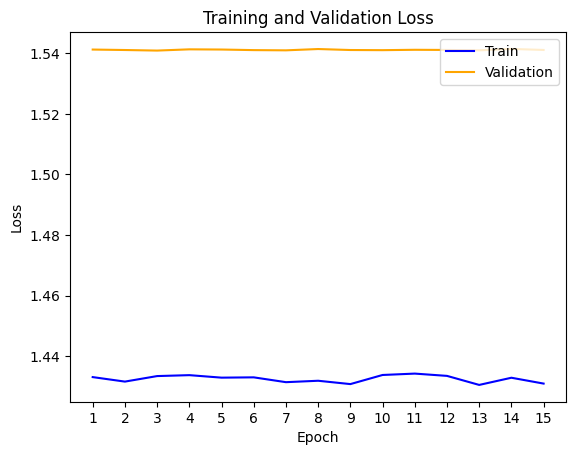

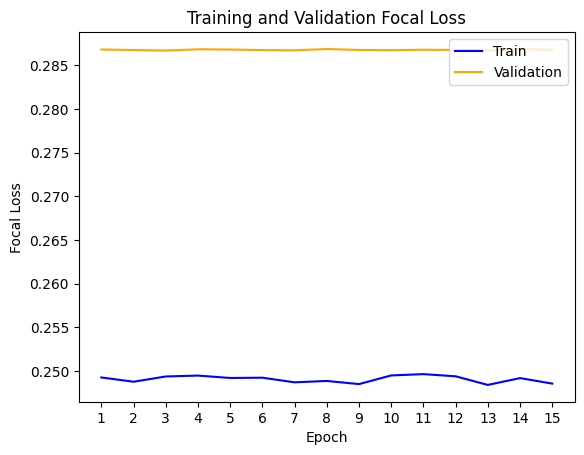

Test Focal Loss: 0.289879
Test Accuracy of Classes

destroyed	: 83% 	 (895/1068)
major-damage	: 6% 	 (210/3500)
minor-damage	: 8% 	 (412/4623)
no-damage	: 1% 	 (161/10108)

Test Accuracy of Dataset: 	 8% 	 (1678/19299)
Accuracy : tensor(0.0869)
F1-score :  tensor(0.0711)
Precision :  tensor(0.3309)
Recall :  tensor(0.0869)


In [51]:
train_eval_model(device, 
                 optimizer, 
                 criterion,
                 train_on_gpu, 
                 class_weights_all, 
                 valid_loader_all, 
                 test_loader_all, 
                 vision_transformer, 
                 epoch, 
                 train_loader_ws_all)

#### Configuration 2

In [52]:
device = setup_device()
vision_transformer=get_vit_model()
epoch = epoches[2]
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, vision_transformer.parameters()),lr=lrs[1],  weight_decay=lambda_wd)
train_on_gpu = torch.backends.mps.is_available()

device =  mps
=============================== Model heads ==========================
Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)
=============================== Model Layers ==========================
Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

Layer Name: encoder.layers.encode

In [53]:
print("Epoches : ", epoch)
print("Weight Decay", lambda_wd)
print(optimizer)

Epoches :  15
Weight Decay 0.0032530002431617774
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0032530002431617774
)


In [ ]:
train_eval_model(device, 
                 optimizer, 
                 criterion,
                 train_on_gpu, 
                 class_weights_all, 
                 valid_loader_all, 
                 test_loader_all, 
                 vision_transformer, 
                 epoch, 
                 train_loader_ws_all)

### Optuna

In [43]:

DEVICE = setup_device()  ##'cuda' or 'cpu'
BATCHSIZE = 128
CLASSES = 4   #CLASSES = 10 for cifar10 and 100 for cifar100
DIR = os.getcwd()
EPOCHS = 10
LOG_INTERVAL = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 504
N_VALID_EXAMPLES = BATCHSIZE * 173

device =  mps


In [44]:
def objective(trial):
    
    model = get_vit_model().to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]) #for hp tuning
    #optimizer_name = "Adam"
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True) #for hp tuning
    #lr = 0.001
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    CEloss = nn.CrossEntropyLoss()  ## this loss object must be used the loop. Directly using nn.CrossEntropyLoss() gives error

    # Get the MNIST dataset.
    train_loader, valid_loader = train_loader_ws_all, valid_loader_all

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            #data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)  ## for mnist
            data, target = data.to(DEVICE), target.to(DEVICE)  ## for cifar 10 and 100

            optimizer.zero_grad()
            output = model(data)
            loss = CEloss(output, target)  ## used cross entropy loss
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            val_loss_batch = 0
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                #data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)  ## for mnist
                data, target = data.to(DEVICE), target.to(DEVICE)  ## for cifar 10 and 100
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

                val_loss_batch += CEloss(output, target).item()  ## used cross entropy loss

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)
        #val_loss_epoch = val_loss_batch / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)
        #trial.report(val_loss_epoch, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy #val_loss_epoch

In [ ]:
study = optuna.create_study(direction="maximize")  # 'maximize' because objective function is returning accuracy
#study = optuna.create_study(direction="minimize")  # 'minimize' because objective function is returning loss
study.optimize(objective, n_trials=30, timeout=600)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-29 19:18:36,549] A new study created in memory with name: no-name-58d18035-ef24-4437-8679-a12da5b44bc6


=============================== Model heads ==========================
Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)
=============================== Model Layers ==========================
Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2

In [ ]:
study.best_trial

In [ ]:
optuna.visualization.plot_optimization_history(study)   

In [ ]:
optuna.visualization.plot_param_importances(study) 

In [ ]:
optuna.visualization.plot_slice(study) 

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)